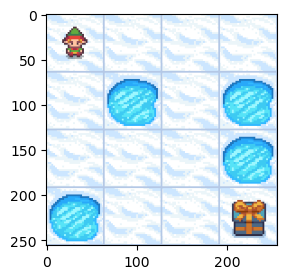

(200, 0)

In [3]:
import gym
#定义环境
#定义环境
class MyWrapper(gym.Wrapper):
    def __init__(self):
        #is_slippery控制会不会滑
        env = gym.make('FrozenLake-v1',
                       render_mode='rgb_array',
                       is_slippery=False)

        super().__init__(env)
        self.env = env
    def reset(self):
        state, _ = self.env.reset()
        return state
    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated
        #走一步扣一份,逼迫机器人尽快结束游戏
        if not over:
            reward =-1
        #掉坑扣100分
        if over and reward == 0:
            reward =-100
        return state, reward, over
    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()

env=MyWrapper()
env.reset()
env.show()

#初始化q表
import numpy as np 
Q=np.zeros((16,4))

from IPython import display
import random
#玩一局游戏并记录数据
def play(show=False):
    state = []
    action = []
    reward = []
    next_state = []
    over = []

    s = env.reset()
    o = False
    while not o:
        a = Q[s].argmax()
        if random.random() < 0.1:
            a = env.action_space.sample()

        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)
        next_state.append(ns)
        over.append(o)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    return state, action, reward, next_state, over, sum(reward)


play()[-1]

#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-1_0000:]

    #获取一批数据样本
    def sample(self):
        return random.choice(self.pool)


pool = Pool()
pool.update()

len(pool), pool[0]

In [4]:
#训练
def train():
    #训练N局
    for epoch in range(50000):

        #玩一局游戏,得到数据
        state, action, reward, next_state,over,_ = play()
        for i in range(len(state)):
            #计算value
            value = Q[state[i], action[i]]

            #计算target
            #累加未来N步的reward,越远的折扣越大
            #这里是在使用蒙特卡洛方法估计target
            reward_s = 0
            for j in range(i, min(len(state), i + 5)):
                reward_s += reward[j] * 0.9**(j - i)

            #计算最后一步的value,这是target的一部分,按距离给折扣
            target = Q[next_state[j]].max() * 0.9**(j - i + 1)

            #如果最后一步已经结束,则不需要考虑状态价值
            #最后累加reward就是target
            target = target + reward_s

            #更新Q表
            Q[state[i], action[i]] += (target - value) * 0.05

        if epoch % 5000 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, test_result)


train()

0 -163.7
5000 -14.2
10000 -14.5
15000 -25.1
20000 -111.85
25000 -9.25
30000 -18.85
35000 -19.7
40000 -9.95
45000 -4.45


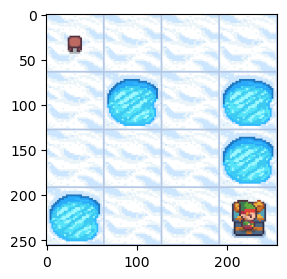

-4.0

In [7]:
play(True)[-1]